# Modeling

### Cleanance

In [1]:
ctry = 'ES'
crop = 'BLUEBERRIES'
regn = 'ANDALUSIA'
catg = 'std'
pkge = 'bulk'
crcy = 'EUR'
msre = 'KG'
mdel = 'SARIMA'

In [2]:
import pyodbc
import pandas as pd
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

qry = f"SELECT * FROM [Prices].[dbo].[prices] where [Country] = '{ctry}' and [Product]='{crop}'"
df_prices = pd.read_sql(qry, connStr)

df_prices.shape

(122, 14)

In [3]:
# Dates in campaign time format
# df_prices['Campaign_Date'] = df_prices['Year_campaign'].astype(str) + df_prices['Week_num_campaign'].astype(str)
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
# df_prices['Campaign_Date'] = df_prices['Campaign_Date'].apply(lambda x: datetime.datetime.strptime(x + '-1', "%Y%W-%w"))

# Dates natural date format
blue = df_prices[(df_prices.Product=='BLUEBERRIES') & (df_prices.Campaign>2015) & (df_prices.Campaign_wk<50)][['Date_price', 'Price']]
blue.set_index('Date_price',inplace=True)
blue.sort_index(inplace=True)
blue.index = blue.index.astype('datetime64[ns]') 
blue_weeks = blue.resample('W-MON').mean()
rows_null = blue_weeks.isnull()
idx_null = rows_null[rows_null.any(axis=1)].index
blue_full = blue_weeks.interpolate()
blue_clean = blue_full[~blue_full.index.isin(idx_null)]


In [4]:
listIndex = list(zip(blue_full.index, range(0,len(blue_full))))     # save all indexes in tuples list (index, idPosition)
listNull = idx_null     # save all null indexes

dfIndex = pd.DataFrame(listIndex)
dfNull = pd.DataFrame(listNull)
dfIndex.columns = ['Date_price','ID']
dfNullID = dfIndex.merge(dfNull, how='inner', on='Date_price')    # this dataframe contains the null indexes with their original index id

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import pmdarima as pm
from pmdarima import model_selection
import datetime
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

print("pmdarima version: %s" % pm.__version__)

pmdarima version: 1.7.0


## Model in production

In [6]:
# load model
ld_model = ARIMAResults.load('model_arima.pkl')

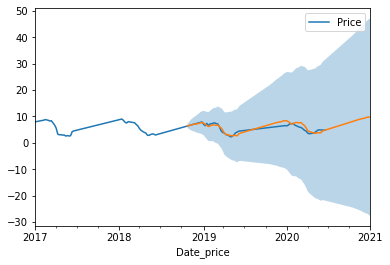

In [7]:
yr = str(datetime.now().year+1)
prediction = ld_model.get_forecast(yr)
lower = prediction.conf_int()['lower Price']
upper = prediction.conf_int()['upper Price']
blue_full.truncate(before='2017').plot()
prediction.predicted_mean.plot()
plt.fill_between(lower.index,lower,upper, alpha=0.3)
plt.show()

In [8]:
# Generate only non-zero prices from last year weeks and current year prediced weeks

df_pred = prediction.predicted_mean.to_frame(name='Price_estimated')
last_yr_wk_zero = dfNullID[dfNullID['Date_price'].dt.year==int(yr)-2]['Date_price'].dt.week
df_pred = df_pred[~df_pred.index.week.isin(last_yr_wk_zero)]

# Mondays and not Sundays as starting day of the week
df_pred.reset_index(inplace=True)
df_pred.set_index(df_pred['index'].apply(lambda x: (x - timedelta(days=x.dayofweek))),inplace=True)
df_pred=df_pred['Price_estimated'].to_frame()
df_pred.tail()

,Price_estimated
index,
2020-05-25,3.789193
2020-06-01,3.745745
2020-06-08,4.291965
2020-12-28,9.745885
2021-01-04,9.699510


## Import prediction data to BI

In [9]:
df_price_model = df_pred.merge(blue,how='right',left_on=df_pred.index,right_on=blue.index).set_index('key_0').reset_index().fillna(0)

In [10]:
import pyodbc
from datetime import datetime, timedelta

connStr = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=bipro02\\adminbi;DATABASE=Prices;Trusted_Connection=yes')
cursor = connStr.cursor()

# Delete all data with price predicted for the country and crop
qry_delete = f"DELETE FROM [Prices].[dbo].[prices_prediction] where [Country] = '{ctry}' and [Product]='{crop}'"
cursor.execute(qry_delete)

# Load all data with price dates greater than the N last days from today
upd = 0

for index,row in df_price_model.iterrows():
    cursor.execute("INSERT INTO dbo.prices_prediction([Product],[Country],[Region],[Category],[Package],[Date_price],[Currency],[Measure],[Model],[Price],[Price_estimated],[Updated]) values (?,?,?,?,?,?,?,?,?,?,?,?)",crop,ctry,regn,catg,pkge,row['key_0'],crcy,msre,mdel,row['Price'],row['Price_estimated'],datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    connStr.commit()
    upd += 1
    #[Product],[Country],[Region],[Category],[Package],[Campaign],[Campaign_wk],[Date_price],[Currency],[Measure],[Model],[Model_measure],[Model_measure_result], [Price], [Price_estimated],[Updated]

print(upd," new prices added")

cursor.close()
connStr.close()

119  new prices added
